# Lattice Dynamics 2: Quasi-Harmonic Approximation

The `thermodynamics` module is developed for both harmonic approximated (HA) and quasi-harmonic approximated (QHA) lattice dynamics. For simplicity, this part is focused only on QHA phonons. For HA, please refer to the [Lattice Dynamics 1: Harmonic Approximation](harmonic.ipynb) example book in the same catagory. For phonon band and density of states, please refer to the [phonons module](../../docs_source/crystalpytools.phonons.rst).

## Basic thermodynamic properties

This part is divided into 3 different testing cases to illustrate the available fitting procedures.

### The 'thermo_freq()' method

The `thermo_freq()` methods implements the 'mode-by-mode' fitting of frequencies.

1. DFT internal energies are fitted as adiabatic equation of states (EOS) defined in [pymatgen.eos](https://pymatgen.org/pymatgen.analysis.html#module-pymatgen.analysis.eos) module, $E_{0}(V)$.  
2. Phonon frequencies (not angular) are fitted as polynomial functions of volume, $\nu(V)$.  
3. The analytical expression of Gibbs free energy is fitted at given temperature and pressure to get the equilibrium volume $\text{min}\{G(V; T,p)\}$.

$\Gamma$ point phonons of Form 1 paracetamols computed at 4 different volumes are fitted. The sequence of input files is arbitrary.

In [1]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

file_list = ['qha_paracetamolGm4.out', 'qha_paracetamolGp4.out',
             'qha_paracetamolGr0.out', 'qha_paracetamolGp8.out']
T = np.array([20, 50, 80, 150, 200, 250, 330], dtype=float)
p = np.linspace(0, 1, 5)

qha = Quasi_harmonic(filename='qha_paracetamolFit.txt', temperature=T,
                     pressure=p).from_HA_files(*file_list)
qha.thermo_freq(eos_method='birch_murnaghan', poly_order=[2, 3],
                min_method='BFGS')

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:792: UserWarning: Close overlap of phonon modes detected at qpoint 0: 173 overlaps out of 240*240 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol=mode_sort_tol)
/tmp/ipykernel_1653/2260797371.py:11: UserWarning: Optimised volume exceeds the sampled range. Special care should be taken of.
  Volume:     731.4041, Temperature:  20.00, Pressure:   0.50

  qha.thermo_freq(eos_method='birch_murnaghan', poly_order=[2, 3],
/tmp/ipykernel_1653/2260797371.py:11: UserWarning: Optimised volume exceeds the sampled range. Special care should be taken of.
  Volume:     726.2165, Temperature:  50.00, Pressure:   0.50

  qha.thermo_freq(eos_method='birch_murnaghan', poly_order=[2, 3],
/tmp/ipykernel_1653/2260797371.py:11: UserWarning: Optimised volume exceeds the sampled range. Special care should be taken of.
  Volume:     735.8975

Warning messages are printed out when the fitted volume data exceeds the sampled volume data. However, tests show that moderate extrapolation tend not to severely deteriorate the results, therefore, a warning, instead of an error, is used.

No warning message is printed out for 0 pressure thermodynamics. The difference is <= 5 cm$^3$/mol, which is a good agreement with experimental measurements. The increased thermal expansion around 50~150K is reproduced.

Experimental Data:

[C. C. Wilson, *Z. Kristallogr. Cryst. Mater.*, 2000, **215**, 693–701](https://www.degruyter.com/document/doi/10.1524/zkri.2000.215.11.693/html)

Text(0, 0.5, 'Volume (cm$^{3}$/mol)')

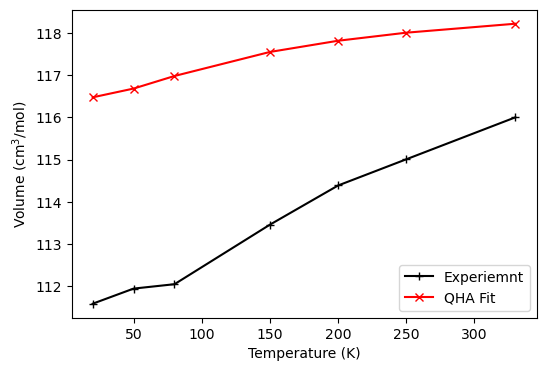

In [2]:
import matplotlib.pyplot as plt

exp = np.array([111.5836, 111.9421, 112.0463, 113.4580, 114.3871, 
                115.0082, 116.0031])
qha_zerop = qha.volume[0, :]
# Angstrom^3 to cm^3/mol
qha_zerop = qha_zerop * 0.602214 / 4

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(T, exp, '+-k', label='Experiemnt')
ax.plot(T, qha_zerop, 'x-r', label='QHA Fit')
ax.legend(loc='lower right')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Volume (cm$^{3}$/mol)')

### The 'thermo_eos()' method

This test is to illustrate the procedure to fit a series of adiabatic EOSs at constant temperature to avoid the mode-specific fittings and calculations, which might be useful for large systems with low symmetry.

1. Harmonic Helmholtz free energy for each sampled volume is used to fit EOS, $F(V; T)$.  
2. The difference between analytical pressure $p(V)=-\left(\frac{\partial F}{\partial V}\right)_{T}$ and the given pressure $p_{0}$ is minimized to get the equilibrium volume, $\text{min}\{(p(V) - p_{0})^{2}\}$.  
3.  $G(T; p)$ is fitted as polynomial function to get entropy, $S=-\left(\frac{\partial G}{\partial T}\right)_p$.

The time consumption and 0 pressure thermal expansion of the `thermo_freq()` and the `thermo_eos()` methods are compared.

In [3]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic
import time

file_list = ['qha_paracetamolGm4.out', 'qha_paracetamolGp4.out',
             'qha_paracetamolGr0.out', 'qha_paracetamolGp8.out']
tempt = np.array([20, 50, 80, 150, 200, 250, 330], dtype=float)
press = np.linspace(0, 1, 5)

mode = Quasi_harmonic(filename=None).from_HA_files(file_list, mode_sort_tol=0.4)
eos = Quasi_harmonic(filename=None).from_HA_files(file_list, mode_sort_tol=None)

tbg = time.perf_counter()
# Mode-specific
mode.thermo_freq(temperature=tempt, pressure=press,
                 eos_method='birch_murnaghan',
                 poly_order=3, min_method='BFGS', mutewarning=True)

tmode = time.perf_counter()
# EoS
eos.thermo_eos(temperature=tempt, pressure=press,
               eos_method='birch_murnaghan',
               poly_order=3, mutewarning=True)

teos = time.perf_counter()
print('Time consumption for Mode-Specific fitting: %12.6f s' % (tmode - tbg))
print('Time consumption for EoS fitting: %12.6f s' % (teos - tmode))

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:792: UserWarning: Close overlap of phonon modes detected at qpoint 0: 173 overlaps out of 240*240 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol=mode_sort_tol)


Time consumption for Mode-Specific fitting:    13.363938 s
Time consumption for EoS fitting:     0.573414 s


0 pressure thermal expansion.

Text(0, 0.5, 'Volume (cm$^{3}$/mol)')

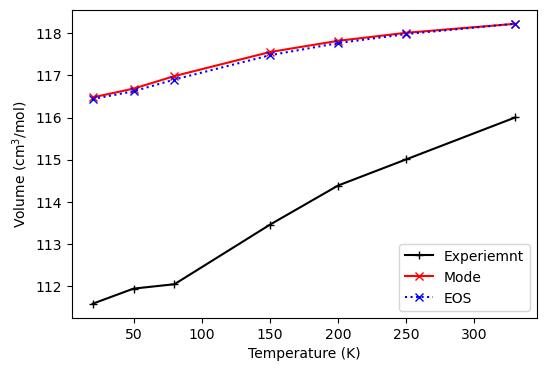

In [4]:
import matplotlib.pyplot as plt

exp = np.array([111.5836, 111.9421, 112.0463, 113.4580, 114.3871,
                115.0082, 116.0031])
# Angstrom^3 to cm^3/mol
vol_mode = mode.volume[0, :] * 0.602214 / 4
vol_eos = eos.volume[0, :] * 0.602214 / 4

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(T, exp, '+-k', label='Experiemnt')
ax.plot(T, vol_mode, 'x-r', label='Mode')
ax.plot(T, vol_eos, 'x:b', label='EOS')

ax.legend(loc='lower right')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Volume (cm$^{3}$/mol)')

It should be noted that entropy $S(V, T)$ is fitted from $S=-\left(\frac{\partial G}{\partial T}\right)_{p}$, making it less accurate compared to mode-specific fittings. See below.

In [5]:
print('{:>3s}{:>10s}{:>10s}{:>16s}{:>16s}'.format('T', 'S(mode)', 'S(EOS)', 'F(mode) 10^6', 'F(EOS) 10^6'))
for i in range(len(mode.temperature)):
    print('{:3.0f}{:10.2f}{:10.2f}{:16.8f}{:16.8f}'.format(
            mode.temperature[i], mode.entropy[0,i], eos.entropy[0,i],
            mode.helmholtz[0,i]/1e6, eos.helmholtz[0,i]/1e6
    ))

  T   S(mode)    S(EOS)    F(mode) 10^6     F(EOS) 10^6
 20     13.13      6.03     -5.40069878     -5.40069878
 50     96.45     99.96     -5.40070032     -5.40070031
 80    192.77    190.23     -5.40070467     -5.40070465
150    388.65    386.61     -5.40072524     -5.40072517
200    512.34    514.67     -5.40074780     -5.40074769
250    629.87    632.55     -5.40077637     -5.40077622
330    810.88    799.98     -5.40083405     -5.40083385


### The 'thermo_gruneisen()' method

In this module, the Grüneisen model is equivalent to `thermo_freq(poly_order=1)`, i.e., $\nu(V)$ is fitted linearly.

An extra set of:

1. Thermal expansion coefficients $\alpha_{v}$, `obj.alpha_vgru`
2. Constant pressure specific heat $C_{p}$, `obj.c_pgru`
3. Adiabatic bulk modulus $K_{S}$, `obj.k_sgru`

are obtained via Grüneisen model (different from properties in the next section).

Read QHA output of Al$_{2}$O$_{3}$ and fit with `thermo_gruneisen` and `thermo_freq`.

In [6]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

file = 'qha_corundumG.out'
T = np.linspace(0, 1000, 5)
p = np.linspace(0, 1, 5)

gru = Quasi_harmonic().from_QHA_file(file)
gru.thermo_gruneisen(temperature=T, pressure=p, eos_method='birch_murnaghan',
                     min_method='BFGS')

freq = Quasi_harmonic().from_QHA_file(file)
freq.thermo_freq(temperature=T, pressure=p, eos_method='birch_murnaghan',
                 poly_order=3, min_method='BFGS')

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:845: UserWarning: Close overlap of phonon modes detected at qpoint 0: 34 overlaps out of 90*90 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol)
/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:845: UserWarning: Close overlap of phonon modes detected at qpoint 0: 34 overlaps out of 90*90 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol)


Comparison of equilibrium volumes.

Text(0, 0.5, 'Volume ($\\AA^{3}$)')

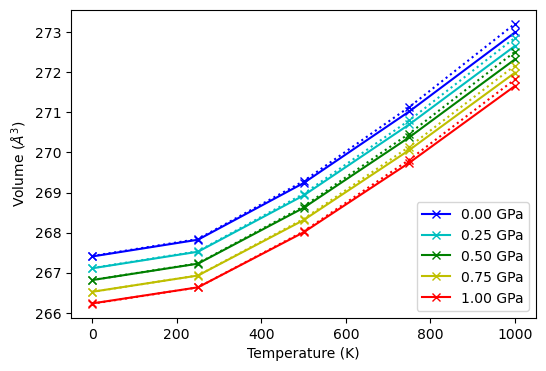

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
style_freq = ['x-b', 'x-c', 'x-g', 'x-y', 'x-r']
style_gru = ['x:b', 'x:c', 'x:g', 'x:y', 'x:r']

for vf, vg, sf, sg, p in zip(
    freq.volume, gru.volume, style_freq, style_gru, freq.pressure
):
    ax.plot(T, vf, sf, label='{:.2f} GPa'.format(p))
    ax.plot(T, vg, sg)

ax.legend(loc='lower right')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Volume ($\AA^{3}$)')

Other thermodynamic properties by Grüneisen model.

In [8]:
print('Macroscopic Grüneisen parameter at 1000K, 0GPa : {:.4f}'.format(gru.gruneisen[0, -1]))
print('Thermal expansion coefficient at 500K, 1GPa : {:.8f}'.format(gru.alpha_vgru[-1, 2]))
print('Constant pressure specific heat at 500K, 1GPa : {:.4f} J/mol/K'.format(gru.c_pgru[-1, 2]))
print('Adiabatic bulk modulus at 500K, 1GPa : {:.4f} GPa'.format(gru.k_sgru[-1, 2]))

Macroscopic Grüneisen parameter at 1000K, 0GPa : 1.4670
Thermal expansion coefficient at 500K, 1GPa : 0.00002444
Constant pressure specific heat at 500K, 1GPa : 621.6709 J/mol/K
Adiabatic bulk modulus at 500K, 1GPa : 221.1216 GPa


## Other thermodynamic properties

After getting the basic properties (equilibirum volum, entropy, Helmholtz free energy and Gibbs free energy) with methods in the previous section, other properties can be obtained with methods in this section.

### The 'expansion_vol()' method

The `Quasiharmonic.expansion_vol()` method fits the volumetric thermal expansion coefficients at constant pressure, $\alpha_{V}(T; p)$.

With `plot` option, the user can inspect the quality of fittings from the interactive window. If `plot=False`, the code will fit $V(T; p)$ with polynomials that maximizes $R^{2}$.

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:845: UserWarning: Close overlap of phonon modes detected at qpoint 0: 34 overlaps out of 90*90 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol)


Set the optimal fit:  3


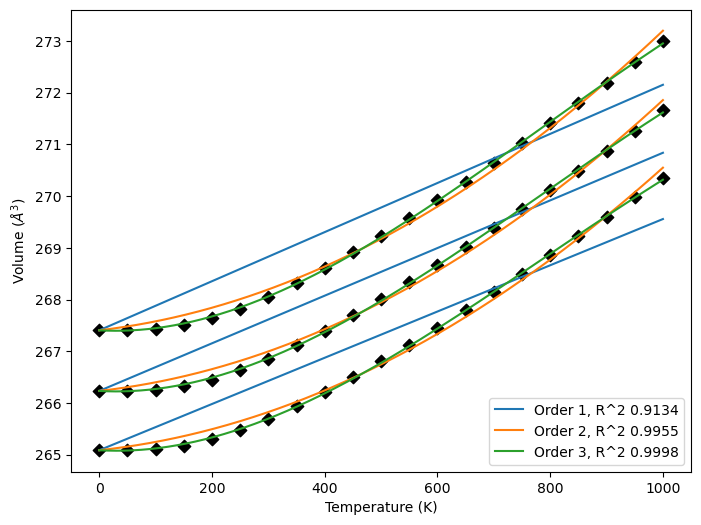

In [9]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

file = 'qha_corundumG.out'
T = np.linspace(0, 1000, 21)

freq = Quasi_harmonic().from_QHA_file(file)
freq.thermo_freq(temperature=T, pressure=[0., 1., 2.], eos_method='birch_murnaghan',
                 poly_order=3, min_method='BFGS')

freq.expansion_vol(poly_order=[1, 2, 3], plot=True,
                   fit_fig='qha_corundumG.png')

Plot $\alpha_{V}$.

Text(0, 0.5, '$\\alpha_{V}$ (10$^{-5}$)')

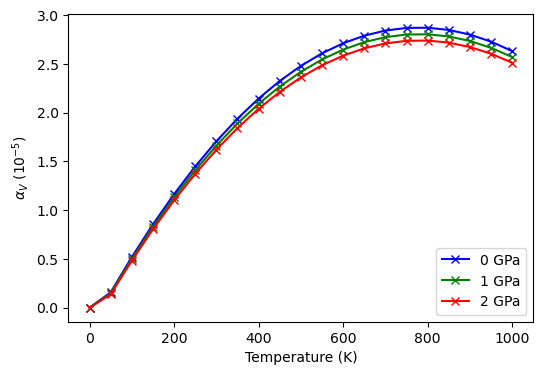

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
style = ['x-b', 'x-g', 'x-r']
for alpha, stl, p in zip(freq.alpha_v, style, freq.pressure):
    ax.plot(T, alpha*1e5, stl, label='{:.0f} GPa'.format(p))

ax.legend(loc='lower right')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\alpha_{V}$ (10$^{-5}$)')

### The 'expansion_lin()' method

The `Quasiharmonic.expansion_lin()` method fits the linear expansion and expansion coefficients of the minimal set of lattice parameters. A multi-dimensional 2-order perturbation is adopted ([N. Raimbault, V. Athavale and M. Rossi, *Phys. Rev. Materials*, 2019, **3**, 053605.](https://link.aps.org/doi/10.1103/PhysRevMaterials.3.053605)).

$$G(\mathbf{p}) = G_{0}(\mathbf{p}_{0}) + \Delta\mathbf{p}^{T}\mathbf{H}\Delta\mathbf{p}$$

$\Delta\mathbf{p}$ is the difference between the lattice parameters of sampled HA calculations and the equilibrium ones (to be fitted). The root-mean-suqared deviation (RMSD) of the following equation is minimized at given temperature and pressure.

$$\mathbf{p_{0}} = \min\left\{\Delta\mathbf{p}^{T}\mathbf{H}\Delta\mathbf{p} - [G(\mathbf{p})-G_{0}(T,p)]\right\}$$

The RMSD of Gibbs free energy is minimized rather than the volume due to the ambiguity and cost. Slight deviations of the fitted lattice volume and the fitted $V_{0}$ might occur. The RMSD of energy is available in output file.

This stragety requires more HA calculations than the method implemented in CRYSTAL. The number of HA calculations should follow the equation below, otherwise the warning massage is given.

$$n_{HA} \geq n_{latt} + \sum_{i=1}^{n_{latt}}i$$

$n_{latt}$ is the lenth of the minimial set of lattice parameters. The optimized lattice parameters at DFT level are used for fitting.

With the `interp` option, interpolated volumes and lattice parameters can be inserted. A smoother curve might be obtained - but not necessarily **CORRECT**. Adding more optimized HA calculations is always preferred.

In [11]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

file = 'qha_corundumG.out'
T = np.linspace(0, 1000, 21)

freq = Quasi_harmonic().from_QHA_file(file)
freq.thermo_freq(temperature=T, pressure=[0., 1., 2.], eos_method='birch_murnaghan',
                 poly_order=3, min_method='BFGS')

freq.expansion_lin(interp=4)

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:845: UserWarning: Close overlap of phonon modes detected at qpoint 0: 34 overlaps out of 90*90 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol)


Plot lattice parameters at 0 GPa.

/tmp/ipykernel_1653/3602586298.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')


Text(0.5, 1.0, 'Lattice Parameter c, 0 GPa')

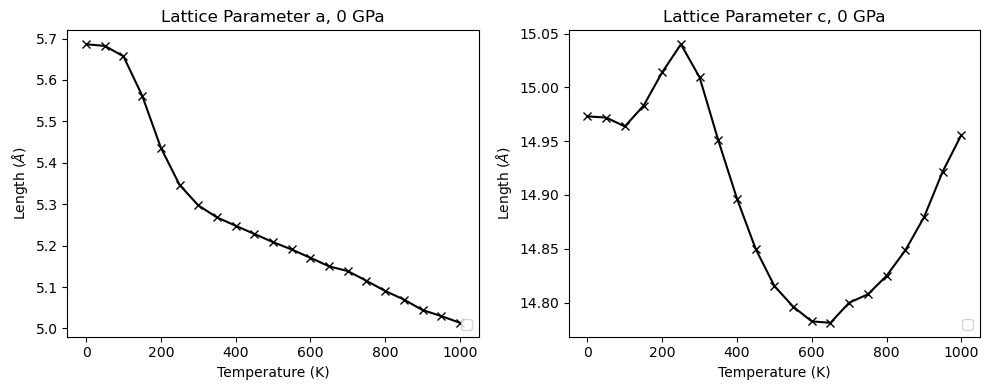

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=False, layout='tight')

for ilatt, ax in enumerate(fig.axes):
    ax.plot(T, freq.lattice[0, :, ilatt], '-xk')
    ax.legend(loc='lower right')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel(r'Length ($\AA$)')

fig.axes[0].set_title('Lattice Parameter a, 0 GPa')
fig.axes[1].set_title('Lattice Parameter c, 0 GPa')

### The 'bulk_modulus' method

The `Quasiharmonic.bulk_modulus()` method computes isothermal $K_{T}$ and adiabatic $K_{S}$ bulk moduli.

To get $K_{T}$, Helmholtz free energy is fit as isothermal EOSs. For `thermo_eos()`, that means doing nothing; For `thermo_freq()` and `thermo_gruneisen`, EOS fitting is required, whose form is the same as EOS used for $E_{0}$.

For $K_{S}$, the `expansion_vol()` method must be called first.

In [13]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

file = 'qha_corundumG.out'
T = np.linspace(0, 1000, 21)

freq = Quasi_harmonic().from_QHA_file(file)
freq.thermo_freq(temperature=T, pressure=[0., 1., 2., 3.],
                 eos_method='birch_murnaghan', poly_order=3,
                 min_method='BFGS')

freq.expansion_vol(poly_order=3, plot=False)
freq.bulk_modulus(adiabatic=True)

print('K_T at 300K, 0GPa = {:.4f} GPa'.format(freq.k_t[0, 6]))
print('K_S at 300K, 0GPa = {:.4f} GPa'.format(freq.k_s[0, 6]))

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:845: UserWarning: Close overlap of phonon modes detected at qpoint 0: 34 overlaps out of 90*90 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol)


K_T at 300K, 0GPa = 221.0665 GPa
K_S at 300K, 0GPa = 222.5323 GPa


### The 'specific_heat()' method

The `Quasiharmonic.specific_heat()` method computes constant volume $C_{V}$ or pressure $C_{p}$ specific heat.

* For `thermo_freq` or `thermo_gruneisen`, this method fits `self.c_p` from `self.c_v`.  
* For `thermo_eos`, this method fits `self.c_v` from `self.c_p`.

The `expansion_vol()` and the `bulk_modulus()` methods must be called first.

In [14]:
import numpy as np
from CRYSTALpytools.thermodynamics import Quasi_harmonic

file = 'qha_corundumG.out'
T = np.linspace(0, 1000, 21)

freq = Quasi_harmonic().from_QHA_file(file)
freq.thermo_freq(temperature=T, pressure=[0., 1., 2., 3.],
                 eos_method='birch_murnaghan', poly_order=3,
                 min_method='BFGS')

freq.expansion_vol(poly_order=3, plot=False)
freq.bulk_modulus(adiabatic=False)
freq.specific_heat()

print('C_V at 300K, 0GPa = {:.4f} J/mol/K'.format(freq.c_v[0, 6]))
print('C_p at 300K, 0GPa = {:.4f} J/mol/K'.format(freq.c_p[0, 6]))

/home/huanyu/apps/anaconda3/envs/crystal_py3.9/lib/python3.9/site-packages/CRYSTALpytools/thermodynamics.py:845: UserWarning: Close overlap of phonon modes detected at qpoint 0: 34 overlaps out of 90*90 mode combinations at this point.
  self.combined_mode, close_overlap = self._combine_data(ha_list, mode_sort_tol)


C_V at 300K, 0GPa = 470.4611 J/mol/K
C_p at 300K, 0GPa = 473.5805 J/mol/K


For more information please refer to the [API documentation](../../docs_source/crystalpytools.thermodynamics.rst).